# Genetic algorithm
Our task is to implement a simple genetic algorithm and use it for solving some simple optimization problems.

## Utilities

In [1]:
import random
import statistics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

In [2]:
def argmax(x):
    ''' Return the index of the highest value in the list '''
    return max(enumerate(x), key=lambda x:x[1])[0]

def mean(x):
    ''' Return the mean of list of numbers '''
    return np.asarray(x).mean()

## Entity

First we implement a generic "Entity" class: instances of this class represent elements in the search space in which are looking for optimal solution(s). As we are using GA, these elements have "genes" which can mutate and crossover.

In [3]:
class Entity:
    ''' Functionality and description of an entity.'''

    def __init__(self, gene_nbr=2, init_range=None):
        """Initialize an entity.

        Args:
          gene_nbr(int): The number of genes in the chromosome.
          init_range (list): A list of (start, end) numeric range pairs for each gene.

        Attributes:
          init_range (list): A list of (start, end) numeric range pairs for each gene. 
            Alleles can vary within these ranges.
          chromosome (list): A list of alleles (values) for each gene.          
          fitness: the numeric fitness value of the entity.
        """
        self.init_range = init_range 
        self.chromosome = [self.random_allele(i) for i in range(gene_nbr)] # chromosome is randomly generated
        self.fitness = None
    
    def random_allele(self, position):
        ''' Generate random value in expected range for a gene '''
        a = random.uniform(self.init_range[position][0], self.init_range[position][1])
        return a
    
    def eval_fitness(self, fitness_fn):
        ''' Calculate fitness given a fitness function '''
        self.fitness = fitness_fn(self.chromosome)
        return self.fitness
    
    def mutation(self, chance=5):
        '''
        Random reset mutation: every gene in the the chromosome has a chance to be reset to a random value.

        Args:
          chance (int): Chance for an individual gene to change, specified in percent.
        '''
        # TASK: implement the mutation method! The method has to iterate over all genes of the entity and 
        # first randomly decide, based on the chance argument, whether the gene should change or not, and if the answer
        # is yes then reset the gene to a random allele (there is already a method for generating proper random alleles...).

        for i in range(len(self.chromosome)):
          if random.randint(0, 100) < chance:
             self.chromosome[i] = self.random_allele(i)

        
        

# Testing the Entity class

In [4]:
# Entity
test_entity = Entity(init_range=[(0,1), (0,1)])
print('Chromosome:', test_entity.chromosome)

Chromosome: [0.8827821574347119, 0.3667705262617218]


In [5]:
# How fitness evaluation works
def fitness_fn(x):
    return x[0] + x[1]

print('Fitness of entity:', test_entity.eval_fitness(fitness_fn))

Fitness of entity: 1.2495526836964337


### Testing the mutation method of the Entity class

In [7]:
# Mutation function test
print('Chromosome before mutation:', test_entity.chromosome)
test_entity.mutation(chance=20)
print('Chromosome after mutation: ', test_entity.chromosome)

Chromosome before mutation: [0.8827821574347119, 0.3667705262617218]
Chromosome after mutation:  [0.8827821574347119, 0.8547200069820894]


## Population

Now we turn to implementing a Population class representing a population of entities in the search space,



In [8]:
class Population:
    ''' Functionality and description of a population of entities.
    
    Attrs:
      gene_nbr(int): The number of genes in the chromosomes.
      init_range (list): A list of (start, end) numeric range pairs for each gene.
      entity_list(list): List of entities in the population.
    '''
    def __init__(self, gene_nbr=2, init_range=None, init_entity_nbr=100):
        """Initialize a population.

        Args:
          gene_nbr(int): The number of genes in the chromosomes.
          init_range (list): A list of (start, end) numeric range pairs for each gene.
          init_entity_nbr (int): Initial number of entities in the population.
        """
        self.gene_nbr = gene_nbr
        self.init_range = init_range
        self.entity_list = [Entity(gene_nbr=gene_nbr, init_range=init_range) for i in range(init_entity_nbr)]
        
    def eval_fitness(self, fitness_fn):
        ''' Calculate fitness of population given a fitness function.'''
        for entity in self.entity_list:
            entity.eval_fitness(fitness_fn)
    def parent_selection(self, n, percent=50):
        ''' Run tournament selection to get n parent pairs.'''
        # Selecting the number of contenders -- it will be contained in the variable k.
        k = int(len(self.entity_list) * percent / 100)
        if k < 5: # we want at least 5 contenders
            k = 5 
        parent_pairs = [] # this list will contain the selected parent pairings
        for i in range(n):
            # We want to select here two parents, parent_a and parent_b on the basis of a "tournament" which 
            # consists of 
            # (i) a random selection of a subpopulation of k entities 
            # (ii) choosing the fittest from this subpopulation.

            # TASK: Implement Tournament A, i.e., the tournament for choosing the first parent, and assign the
            # winner to the variable parent_a. The argmax function defined above can be useful for (ii).

            contenders = random.sample(self.entity_list, k=k)
            parent_a = max(contenders, key=lambda entity: entity.fitness)

            # TASK: Implement Tournament B for selecting the second parent and assign the winner to the variable parent_b.

            contenders = random.sample(self.entity_list, k=k)
            parent_b = max(contenders, key=lambda entity: entity.fitness)

            parent_pairs.append((parent_a, parent_b))

        return parent_pairs

    def crossover(self, parent_pairs):
        ''' Aka making babies. Uniform crossover.

        Args:
          parent_pairs (list): The list of parent entity pairs for the crossover.
        '''
        self.new_entity_list = []
        for parent_a, parent_b in parent_pairs:
            new_entity = Entity(gene_nbr=self.gene_nbr, init_range=self.init_range) # create the offspring

            # TASK: Implement the crossover!
            # Each gene in the off-spring's chromosome should have 50% chance to get parent A's value otherwise 
            # it gets parent B's.

            for i in range(self.gene_nbr):
                if random.random() < 0.5:
                    new_entity.chromosome[i] = parent_a.chromosome[i]
                else:
                    new_entity.chromosome[i] = parent_b.chromosome[i]

            self.new_entity_list.append(new_entity)
        
    def mutation(self, chance=5):
        ''' Apply mutation to population '''
        for entity in self.entity_list:
            entity.mutation(chance)
            
    def survivor_selection(self, percent=95):
        ''' Remove the n least fit entity '''
        n = int(len(self.entity_list) * (1 - percent / 100))
        
        # Get fitnesses
        fitnesses = [entity.fitness for entity in self.entity_list]
        fitnesses.sort()
        
        # Remove least fit
        self.entity_list = self.entity_list[n:]
        
        # Add newly "born" entities
        self.entity_list += self.new_entity_list

### Testing the parent selection functionality of the Population class

In [9]:
# Create a population for test purpuses
population = Population(gene_nbr=5, init_range=[(0,1)] * 5)

# Evaluate fitness for entities in population
def fitness_fn(x):
    component_1 = np.sin(2 * np.pi / 2 * x[0]) * np.sin(2 * np.pi / 3 * x[1])
    component_2 = np.exp(x[2]) / (x[3] + 0.5)
    return component_1 + component_2 + x[4]

population.eval_fitness(fitness_fn)

In [10]:
# Test implemented function
parent_pairs = population.parent_selection(n=3, percent=5)
parent_pairs

[(<__main__.Entity at 0x272eea74eb0>, <__main__.Entity at 0x272eea62af0>),
 (<__main__.Entity at 0x272eea743d0>, <__main__.Entity at 0x272eea771c0>),
 (<__main__.Entity at 0x272eea77c40>, <__main__.Entity at 0x272eea74eb0>)]

### Testing the  crossover function for the Population class

In [11]:
# Test implemented function
population.crossover(parent_pairs)

# Print information for debugging
for (parent_a, parent_b), offspring in zip(parent_pairs, population.new_entity_list):
    print('Parent A   chromosome:', parent_a.chromosome)
    print('Parent B   chromosome:', parent_b.chromosome)
    print('Off-spring chromosome:', offspring.chromosome)
    print()

Parent A   chromosome: [0.056457672203250486, 0.7490097181863227, 0.8000953534669508, 0.16460421513603463, 0.333458263168243]
Parent B   chromosome: [0.7309448004251893, 0.0670845655377138, 0.9372558981811512, 0.3485079014681396, 0.9630883303106995]
Off-spring chromosome: [0.056457672203250486, 0.0670845655377138, 0.8000953534669508, 0.3485079014681396, 0.9630883303106995]

Parent A   chromosome: [0.4497956963547255, 0.9793971058955054, 0.583444322086035, 0.2200758815848297, 0.023958977710627494]
Parent B   chromosome: [0.6971897255790663, 0.525923673701313, 0.6538827040156291, 0.19815391610752586, 0.22627260797886828]
Off-spring chromosome: [0.4497956963547255, 0.9793971058955054, 0.583444322086035, 0.19815391610752586, 0.023958977710627494]

Parent A   chromosome: [0.44949973728428283, 0.6430111213933519, 0.10396798911751837, 0.01884573618933072, 0.08706537799479419]
Parent B   chromosome: [0.056457672203250486, 0.7490097181863227, 0.8000953534669508, 0.16460421513603463, 0.333458263

## Genetic algorithm
### Testing convergence


In [12]:
# Hyperparameters
init_entity_nbr = 100
iteration = 200
nbr_of_offspring = 10
tournament_participation_percent = 50
mutation_percent = 2
survivor_percent = 99 # 92

Maximum fitness: 7.3616718373554955


Text(0.5, 0, 'iteration')

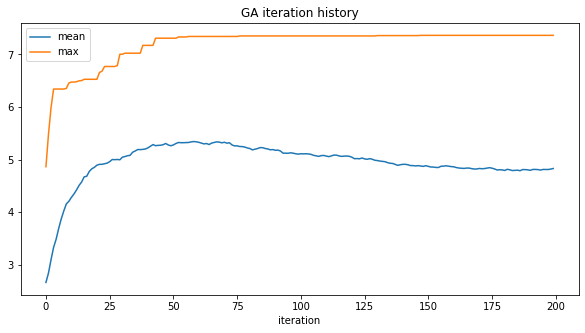

In [13]:
# Genetic algorithm
population = Population(gene_nbr=5, init_range=[(0,1)] * 5, init_entity_nbr=init_entity_nbr)

history_mean = []
history_max = []
for i in range(iteration):
    # Evaluate fitness
    population.eval_fitness(fitness_fn)
    
    # Save data for plot
    history_max.append(max([entity.fitness for entity in population.entity_list]))
    history_mean.append(mean([entity.fitness for entity in population.entity_list]))
    
    # Find parents
    parent_pairs = population.parent_selection(n=nbr_of_offspring, percent=tournament_participation_percent)
    
    # Crossover
    population.crossover(parent_pairs)

    # Mutation
    population.mutation(chance=mutation_percent)
    
    # Kill unfit entities
    population.survivor_selection(percent=survivor_percent)

# Maximum fitness
print('Maximum fitness:', max(history_max))

# Plot history
plot_df = pd.DataFrame()
plot_df['mean'] = history_mean
plot_df['max'] = history_max
ax = plot_df.plot(figsize=(10,5))
ax.set_title('GA iteration history')
ax.set_xlabel('iteration')

### A "Real life" example
X city wants to optimize public transport expenditures. Their study estimated the tax revenue loss of the city to be 1 euro for every hour spent with traveling. Since the subway system moves the most people they decided to optimize it first.

Unfortunetly, if the city decreases travel time by increasing speed limits and acceleration then the energy and maintanance costs rise. Let's help them optimize the travel parameters between two station!

Their automatic subway train has three parameter which can be set: acceleration rate, maximum speed, deceleration rate.

- During the first stage the train accelerates to maximum speed.
- During the second stage the train travels with it's maximum speed.
- During the last stage the train decelerates until it stops.

Cost model parts:
- Energy cost (kinetic energy, regenerative breaking, drag from air resistance)
- Maintanance cost (motors, moving parts and rails don't like high accelerations)
- Lost tax revenue due to lower productivity

In [14]:
# Route and train parameters
s = 4200 # [m] route length
v_abs_max = 24 # [m/s] max speed 
m = 10 * 38600 # [kg] weight 
k = 18 # drag coeff. [kg/m]

a1_abs_max = 1 # [m/s^2] hardware limit -- max. acceleration rate
a3_abs_max = 2 # [m/s^2] safety limit -- max decceleration rate

energy_price = 0.2 # [EUR / kWh]
energy_price = energy_price / 1000 / 3600 # [EUR / Ws]

tax_loss = 1 / 3600 # [EUR / s / people]

passenger_mean = 100 # [pcs]

In [17]:
# Fitness function
def fitness_fn_2(x): # an x is list ("chromosome") of (maximum speed, acceleration rate, deceleration rate)
    # Cost model
    v_max = x[0] # [m/s] # max speed
    a1 = x[1] # [m/s^2] # acceleration
    a3 = x[2] # [m/s^2] # deceleration rate
    
    # Time and length 
    t1 = v_max / a1 # time of acceleration until max speed is reached
    s1 = a1 / 2 * t1 * t1 # covered length during acceleration stage
    
    t3 = v_max / a3 # time of deceleration until stop
    s3 = a3 / 2 * t3 * t3 # covered length during deceleration stage

    s2 = s - s1 - s3 # length of max speed travel
    t2 = s2 / v_max # time of max speed travel
    
    t = t1 + t2 + t3 # total time

    # Energy balance
    # Drag
    E_drag_1 = k * pow(a1, 3) * pow(t1, 5) / 5 
    E_drag_2 = (k * v_max * v_max) * v_max * t2
    E_drag_3 = k * pow(a3, 3) * pow(t3, 5) / 5
    E_drag = E_drag_1 + E_drag_2 + E_drag_3

    E_kinetic = (m /2 * v_max * v_max) # kinetic energy 

    E_regen_3 = (1 - np.exp(-a3)) / a3 * E_kinetic  # energy got back from regenerative breaking 
    
    E_overall = E_kinetic - E_regen_3 + E_drag # full energy used
    
    # Maintanance
    m_a1 = 3 * a1
    m_a3 = 6 * a3
    
    # Price components
    cost_energy = E_overall * energy_price # energy cost
    cost_tax = passenger_mean  * t * tax_loss # tax loss because passengers travel for t time 
    cost_maintanance = m_a1 + m_a3 # maintenance cost
    
    cost = cost_energy + cost_tax + cost_maintanance
    
    # Fitness
    # TASK: We have to return an appropriate fitness value of this particular max_speed, acceleration and deceleration 
    # combination. Please remember that we want to __minimize__ the cost by maximizing fittness...
    
    fitness = -cost
    
    return fitness

In [18]:
# How complicated is the fitness function?
init_range = [(1, v_abs_max), (0, a1_abs_max), (0, a3_abs_max)]
population = Population(gene_nbr=3, init_range=init_range, init_entity_nbr=3000)
population.eval_fitness(fitness_fn_2)

plot_df = pd.DataFrame([entity.chromosome for entity in population.entity_list], columns=['v_max', 'a1', 'a3'])
plot_df['fitness'] = [entity.fitness for entity in population.entity_list]
plot_df['fitness'] = plot_df['fitness'].clip(0, plot_df['fitness'].max() * 1.5)

fig = px.scatter_3d(plot_df, x='v_max', y='a1', z='a3', color='fitness')
fig.show()

In [19]:
# Hyperparameters
init_entity_nbr = 50
iteration = 50
nbr_of_offspring = int(0.1 * init_entity_nbr)
tournament_participation_percent = 30
mutation_percent = 10
survivor_percent = 90

Maximum fitness: -15.182759163294286


Text(0.5, 0, 'iteration')

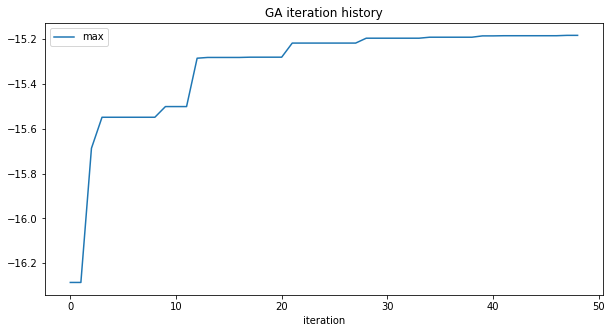

In [23]:
# Genetic algorithm
population = Population(gene_nbr=3, init_range=init_range, init_entity_nbr=init_entity_nbr)

history_mean = []
history_max = []
for i in range(iteration):
    # Evaluate fitness
    population.eval_fitness(fitness_fn_2)
    
    if i < iteration -1:
        # Save data for plot
        history_max.append(max([entity.fitness for entity in population.entity_list]))
        history_mean.append(mean([entity.fitness for entity in population.entity_list]))

        # Find parents
        parent_pairs = population.parent_selection(n=nbr_of_offspring, percent=tournament_participation_percent)

        # Crossover
        population.crossover(parent_pairs)

        # Mutation
        population.mutation(chance=mutation_percent)

        # Kill unfit entities
        population.survivor_selection(percent=survivor_percent)

# Maximum fitness
print('Maximum fitness:', max(history_max))

# Plot history
plot_df = pd.DataFrame()
#plot_df['mean'] = history_mean
plot_df['max'] = history_max
ax = plot_df.plot(figsize=(10,5))
ax.set_title('GA iteration history')
ax.set_xlabel('iteration')

In [21]:
# Plot population of last cycle
plot_df = pd.DataFrame([entity.chromosome for entity in population.entity_list], columns=['v_max', 'a1', 'a3'])
plot_df['fitness'] = [entity.fitness for entity in population.entity_list]
plot_df['fitness'] = plot_df['fitness'].clip(0, plot_df['fitness'].max()*1.5)

fig = px.scatter_3d(plot_df, x='v_max', y='a1', z='a3', size_max=10, color='fitness')
fig.show()